In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from geopandas import read_file, GeoDataFrame


def generate_grid(gdf):

    # Step 2: Create a grid of polygons
    polygons = []
    values = []
    for i_line in range(1, 179):
        for i_column in range(360):
            # Get the current point and the next point
            p1 = gdf.iloc[(361 * i_line) + ((181 + i_column) % 361)].geometry
            p2 = gdf.iloc[(361 * (i_line + 1)) + ((181 + i_column) % 361)].geometry
            p3 = gdf.iloc[(361 * (i_line + 1)) + ((181 + i_column + 1) % 361)].geometry
            p4 = gdf.iloc[(361 * i_line) + ((181 + i_column + 1) % 361)].geometry

            # Create a polygon using the four points
            polygon = Polygon([p1, p2, p3, p4])
            polygons.append(polygon)
            values.append(gdf.iloc[361 * i_line + (181 + i_column) % 361]["EWH"])

    # Step 3: Create a new GeoDataFrame with the polygons
    return gpd.GeoDataFrame({"EWH": values}, geometry=polygons, crs=gdf.crs)


file = "/home/maxime/.cache/pooch/7dd514faeaa71efe73294dece9245e99-continents.zip"
continents: GeoDataFrame = read_file("zip://" + file)
continents.crs = "EPSG:4326"

# Define the limit for EWH values
limit = 8  # Example threshold, adjust as needed
buffer_distances = [50, 100, 200, 300, 400, 500, 600, 700, 800]
equal_earth_crs = 3857

/home/maxime/miniconda3/envs/venv/lib/python3.12/site-packages/pymssa/mssa.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


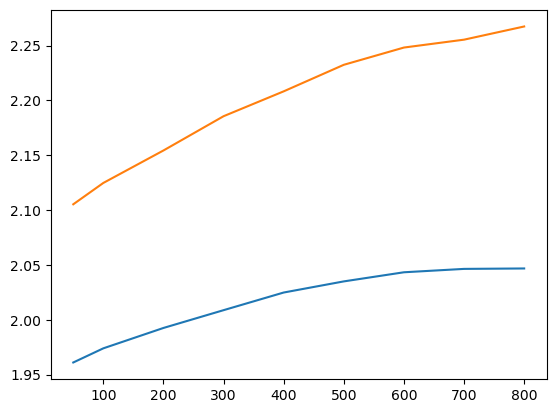

In [2]:
from matplotlib.pyplot import plot, show

from shapely.geometry import Point
from snrei.utils import extract_GRACE_data


for name in [
    "GRACE_MSSA_2003_2022.xyz", "TREND_GRACE(-FO)_MSSA_2003_2022_NoGIA_PELTIER_ICE6G-D.csv"]:
    EWH, latitudes, longitudes = extract_GRACE_data(name=name)

    # Adjust longitude in EWH to shift from 0-360 to -180 to 180
    longitudes = [(lon - 360 if lon > 180 else lon) for lon in longitudes]

    # Convert EWH to a DataFrame with adjusted longitude
    ewh_df = pd.DataFrame(EWH, columns=longitudes, index=latitudes)
    ewh_df = ewh_df.stack().reset_index()
    ewh_df.columns = ["latitude", "longitude", "EWH"]

    # Convert to GeoDataFrame
    ewh_df["geometry"] = ewh_df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
    ewh_gdf = gpd.GeoDataFrame(ewh_df, geometry="geometry")
    ewh_gdf.crs = "EPSG:4326"
    ewh_gdf = generate_grid(ewh_gdf)

    # Use a different projection (Equal Earth)
    continents_projected = continents.to_crs(crs=equal_earth_crs)
    ewh_gdf_projected = ewh_gdf.to_crs(crs=equal_earth_crs)

    mean = []

    for buffer_distance in buffer_distances:

        # Apply a buffer around the continents to exclude areas close to land
        continents_buffered: GeoDataFrame = continents_projected.copy()
        continents_buffered["geometry"] = continents_buffered.buffer(buffer_distance * 1e3)

        # Perform a spatial join to identify points on land or near land
        land_gdf = gpd.sjoin(ewh_gdf_projected, continents_buffered, predicate="intersects")

        # Identify oceanic points by selecting points not in land_gdf
        oceanic_gdf = ewh_gdf_projected.loc[~ewh_gdf_projected.index.isin(land_gdf.index)].loc[abs(ewh_gdf_projected["EWH"]) < limit]

        # Compute the mean EWH value over the oceanic points
        oceanic_mean = oceanic_gdf["EWH"].mean()

        mean += [oceanic_mean]

    plot(buffer_distances, mean)
show()

In [3]:
6378000*3.14/2/1e7

1.001346

<Axes: >

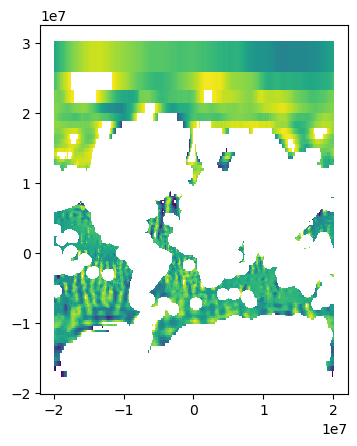

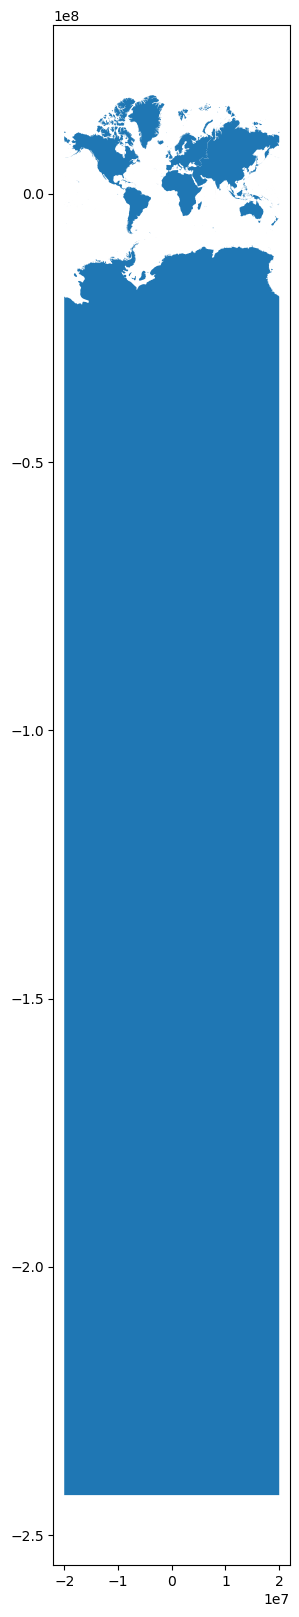

In [4]:
oceanic_gdf.plot("EWH")
continents_projected.plot(figsize=(5, 20))